# Image Patches

We would like to remove patches from images and have a network learn how to fill in these missing patches. 

## Copy an Image from Input to Output

To start, let's just build a network that takes and image as an input and generates the same image at the output.

In [25]:
import os
import json

from fastai2.basics import DataBlock, RandomSplitter

from fastai2.vision.all import ImageBlock, PILMask, get_image_files
from fastai2.vision.core import get_annotations
from fastai2.vision.augment import aug_transforms, RandomResizedCrop
from fastai2.vision.learner import unet_learner, unet_config

from fastai2.data.external import download_url, URLs, untar_data

from torch.nn import MSELoss
from torchvision.models import resnet34

### Get Data: PascalVOC

In [13]:
pascal_path = untar_data(URLs.PASCAL_2012)
pascal_path

Path('/home/josh/.fastai/data/pascal_2012')

In [41]:
# Let's only work with some of the images so we can speed things up
def first_thousand_images(path):
    img_files = get_image_files(path/'train')[:1000]
    return img_files

In [21]:
data = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=some_image_files,
                   splitter=RandomSplitter(),
                   get_y=lambda o: o)

In [34]:
databunch = data.databunch(pascal_path/'train', 
                           bs=8, 
                           item_tfms=RandomResizedCrop(460, min_scale=0.75), 
                           batch_tfms=[*aug_transforms(size=224, max_warp=0)])
# HACK: We're predicting pixel values, so we're just going to predict an output for each RGB channel
databunch.vocab = ['R', 'G', 'B']


Let's look at the images. On the left are input images, and on the right is the image we would like to generate.

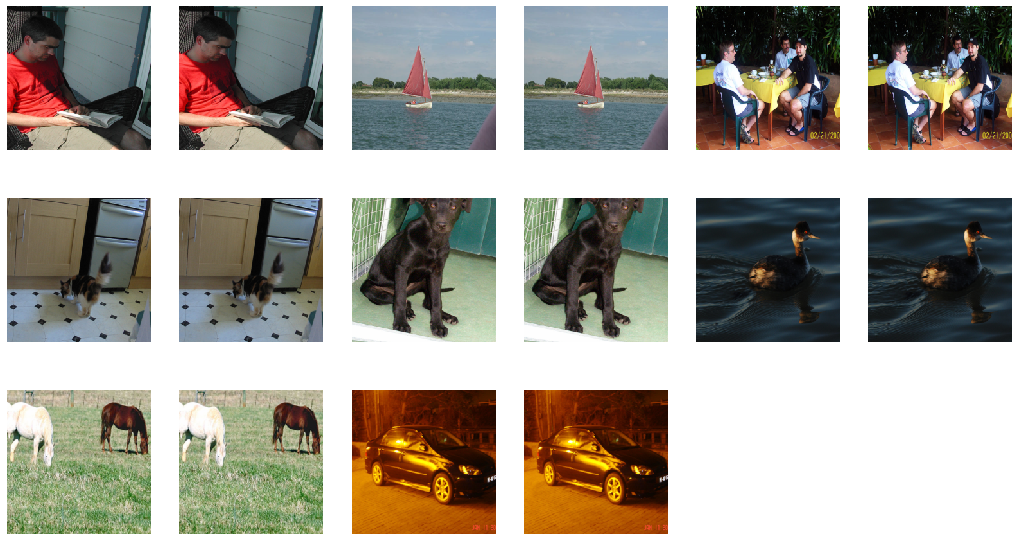

In [35]:
databunch.show_batch(max_n=9)

In [49]:
loss = MSELoss()
learn = unet_learner(databunch, resnet34, config=unet_config(), loss_func=loss)

epoch,train_loss,valid_loss,time
0,0.673493,0.653939,00:22


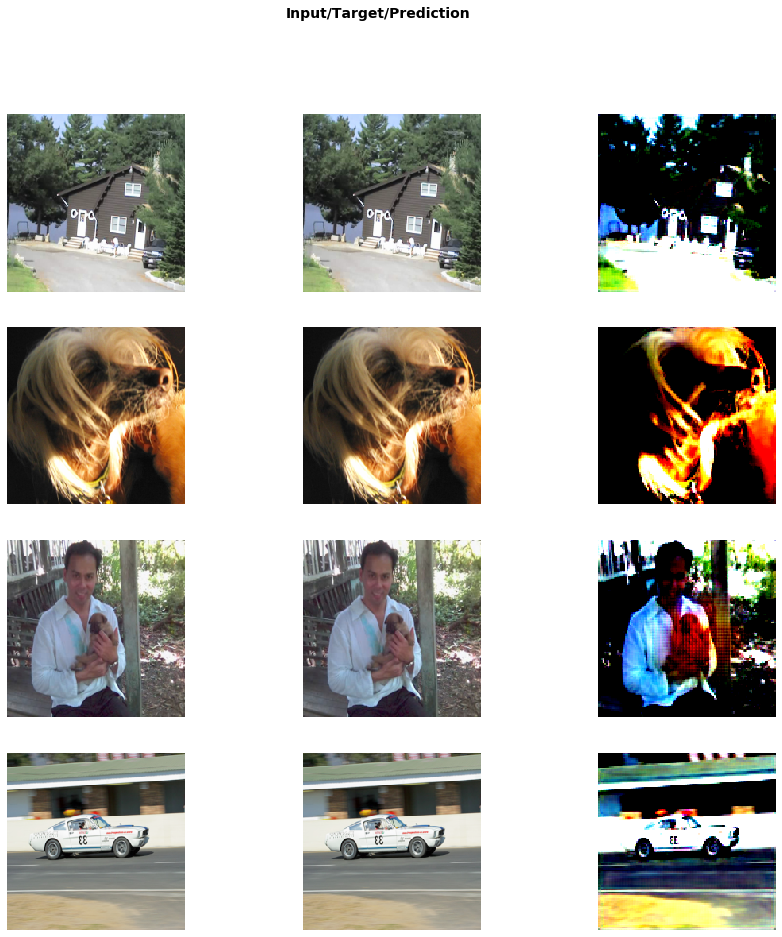

In [50]:
# To get a sense of the task, let's just use a small learning rate and 1 epoch
# That way we'll be able to see the output before the model becomes perfect at this task
learn.fit_one_cycle(1, 1e-3)
learn.predict(databunch.train_ds.items[0]);
learn.show_results(max_n=4, figsize=(15,15))

We can see the network has started to learn to output similar images, but needs a litle bit more time (or a higher learning rate).

epoch,train_loss,valid_loss,time
0,0.254970,0.090545,00:22
1,0.039549,0.002446,00:23
2,0.008866,0.001551,00:23


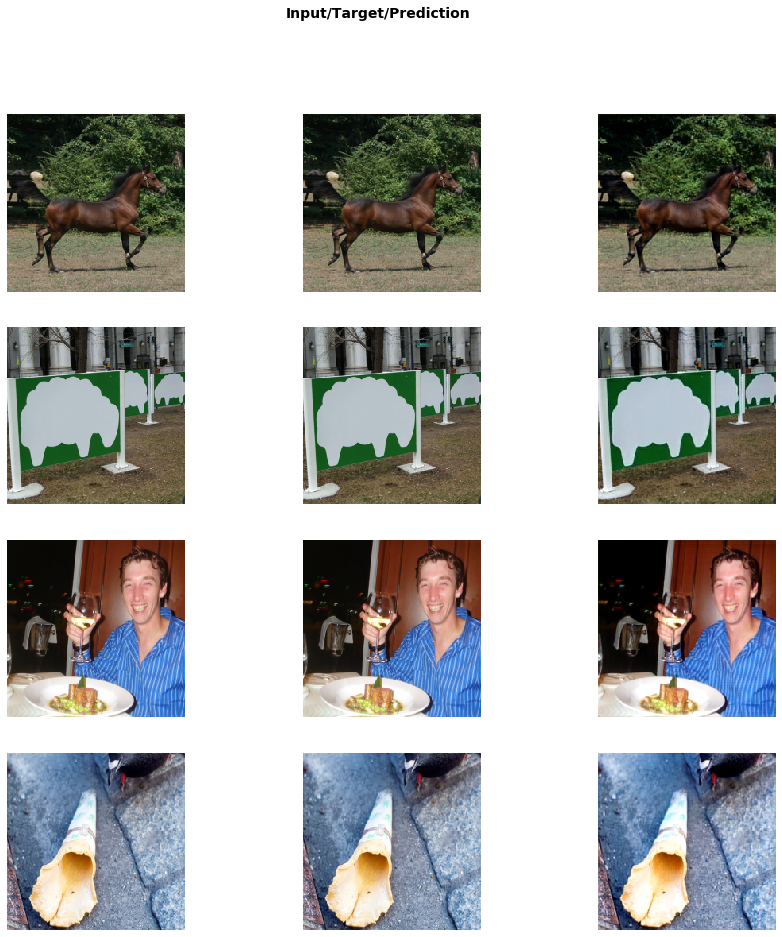

In [51]:
learn.fit_one_cycle(3, 1e-2)
learn.predict(databunch.train_ds.items[0]);
learn.show_results(max_n=4, figsize=(15,15))

Now it works pretty well!